In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import tensorflow as tf
from tensorflow.contrib.layers import dropout
import numpy as np
import pandas as pd
import pickle
import sys
np.set_printoptions(suppress=True)
tf.reset_default_graph()

# TODO / NEED TO IMPLEMENT
# Avoid overfitting through regularization:
# 1. Activation type = linear
# 2. Optimizer - Adam
# 3. Dropout layer: experiment with parameter
# 4. early_stopping = EarlyStopping(monitor='val_loss', patience=3)
# 5. rename to epochs and batches
# 6. implement class class LossHistory
# 7. implement TensorBoard to visualize training and accuracy testing
# 8. test different activations and optimizers
# END TODO

# epoch (=1 full iteration) => 200 steps (# of batches) ==> to run batch of size 100  = 20,000 records
# Define hyperparameters
n_steps = 100  # length of each time series
n_inputs = 1  # MEANING => number of columns
n_neurons = 100
n_outputs = 1
n_layers = 5
keep_prob = 0.5 # MEANING =>
learning_rate = 0.0001
is_training = True
n_iterations = 10 #2000
days = 5 # days to forecast
training_set_percent_of_total = 0.7

daysback=500 #training window, days
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs], name="regressorsX")
y = tf.placeholder(tf.float32, [None, days, n_outputs], name="dependentY") 

tickers  = ["FB","MSFT","AAPL", "AMZN","GOOG"] 

d1 = pickle.load(open("/home/ubuntu/portfolio/factors/stock_data.pkl","rb"))
d2 = d1[d1["ticker"].isin(tickers)][["Close","ticker"]]
ts_df = d2.reset_index().pivot(index="Date", columns='ticker', values='Close')[-252:]
ts = ts_df.values

def replaceOutlier(TS):
    for n in list(TS.columns):
        length = len(TS[n])
        for i in range(0, length, 100):
            p_mean = TS[n][i:i+100].mean()
            l_bound = p_mean * 0.1 
            u_bound = p_mean * 3 
            TS[n][i:i+100][TS[n][i:i+100] > u_bound] = 0
            TS[n][i:i+100][TS[n][i:i+100] < l_bound] = 0
        TS[n].replace(to_replace=0, method='bfill', inplace = True)
    return TS

# OBJECTIVE: Prepare 3-d array [batch, ts, features] where ts is shifted by T+1 for each batch
def PrepareTrainingBatches(ds): # dataframe [daily index, cols = closing PX by ticker]
    X = n_steps
    if len(ds) % 2 != 0:
        ds.drop(ds.index[:1], inplace=True)
    ds = replaceOutlier(ds[-daysback:]) 
    #ds = wave(ds) # reduce ts noise via wavelet
    tickers = list(ds.columns)
    total = len(ds)
    #days = ds.shape[1] #days to forecast = total tickers in the portfolio subset
    remainder = total - X - days
    print("total",total)
    print("X",X)
    print("days",days)
    print("remainder",remainder)
    # *** NORMALIZE ****
    d1 = ds.astype('float32')
    df = np.nan_to_num(np.diff(np.log(d1), axis=0))  # Replace nan with zero and inf with finite numbers.
    data = 1 / (1 + np.exp( (df - df.mean()) / df.std() )  )
    features = ds.shape[1]  #num of dimensions aka columns                
    # *** TRAIN & TEST DATA PREP ****
    #print("remainder",remainder)
    baseX = np.asarray([data[i:X+i] for i in range(1,remainder-1)]) 
    #baseY = np.asarray([data[X+i] for i in range(1,remainder-1)])
    baseY = np.asarray([data[X+i:X+i+days] for i in range(1,remainder-1)])
    startX = int(np.round(training_set_percent_of_total*len(baseX),0))
    startY = int(np.round(training_set_percent_of_total*len(baseY),0))
    # Data to train TF RNN model on.
    trainX = baseX[:startX]
    trainY = baseY[:startY] # reshape input to be [# of batches, time steps, features]
    # Data to predict out of sample and measure accuracy of the trained forecasting model
    testX = baseX[startX:]
    testY = baseY[startY:]
    # BEGIN ACTUAL TIME SERIES FOR FORWARD TEST #
    d1 =  np.nan_to_num(d1)  
    ds_baseX = np.asarray([d1[i:X+i] for i in range(1,remainder-1)]) 
    #ds_baseY = np.asarray([d1[X+i] for i in range(1,remainder-1)])
    ds_baseY = np.asarray([d1[X+i:X+i+days] for i in range(1,remainder-1)])
    ds_startX = int(np.round(training_set_percent_of_total*len(ds_baseX),0))
    ds_startY = int(np.round(training_set_percent_of_total*len(ds_baseY),0))
    ds_trainX = ds_baseX[:ds_startX]
    ds_trainY = ds_baseY[:ds_startY] # reshape input to be [# of batches, time steps, features]
    ds_testX = ds_baseX[ds_startX:]
    ds_testY = ds_baseY[ds_startY:]
    # END ACTUAL TIME SERIES FOR FORWARD TEST #
    # *** END TRAIN & TEST DATA PREP ****
    return {"trainX":trainX,"trainY":trainY,"testX":testX,"testY":testY,
           "dfmean":df.mean(), "dfstd":df.std(),
            "ds_trainX":ds_trainX,"ds_trainY":ds_trainY,"ds_testX":ds_testX,"ds_testY":ds_testY,
            "train_batches": len(trainX), "test_batches": len(testX)
           }


batch_data = PrepareTrainingBatches(ts_df)
t1 = batch_data
train_batches = batch_data["train_batches"]
test_batches = batch_data["test_batches"]
print("train_batches",train_batches)
print("test_batches",test_batches)

def next_batch(batch_type, i):
    if batch_type == "train":
        return batch_data.get("trainX")[i], batch_data.get("trainY")[i]
    elif batch_type == "test":
        return batch_data.get("testX")[i], batch_data.get("testY")[i], batch_data.get("ds_testX")[i], batch_data.get("ds_testY")[i]
    else:
        raise Exception("unknown batch type")

# GRAPH DEFINITION
def deep_rnn_with_dropout(X, y, is_training):
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.relu)
    if is_training:
        cell = tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)  
    multi_layer_cell = tf.contrib.rnn.MultiRNNCell([cell] * n_layers)
    rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
    stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
    stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
    outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
    outputs = outputs[:,:days,:]
    loss = tf.reduce_sum(tf.square(outputs - y))  # forecast vs. actual   # Cost / loss function
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)
    return outputs, loss, training_op

outputs, loss, training_op = deep_rnn_with_dropout(X, y, is_training)

correct_pred = tf.equal(tf.argmax(outputs,1), tf.argmax(y,1)) # outputs = pred
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

#sys.exit()

# END GRAPH DEFINITION
# BEGIN TF OP: TRAINING STEP
rs = {}
init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:
    if is_training: # TRAIN & SAVE TO BE ABLE TO PREDICT INSTANTLY!
        init.run()
        for iteration in range(n_iterations):
            for i in range(0,train_batches):
                X_batch, y_batch = next_batch("train",i) # X = n-days time series, y = next day to predict..  next_batch(batch_size, n_steps)
                X_batch= np.reshape(X_batch, [-1,n_steps, n_inputs])
                y_batch = np.reshape(y_batch, [-1,days, n_inputs])
                sess.run([training_op, outputs], feed_dict={X: X_batch, y: y_batch}) 
            if iteration % 1 == 0:
                mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
                print(iteration, "\tMSE:", mse)
                y_pred = sess.run(outputs, feed_dict={X: X_batch})
                correct_pred = tf.equal(tf.argmax(y_pred,1), tf.argmax(y_batch,1))
                accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
                train_losses.append(mse)
                train_accuracies.append(accuracy)
                              
        save_path = saver.save(sess, "/tmp/my_model.ckpt")
    print("done training")

    # Evaluate Your System on the Test Set
    # Restore pre-trained model
    
    saver.restore(sess, "/tmp/my_model.ckpt")
    # estimate accuracy of the model
    for iteration in range(n_iterations):
        for i in range(0,test_batches):
            X_batch, y_batch,  ds_testX, ds_testY = next_batch("test",i) # X = n-days time series, y = next day to predict..  next_batch(batch_size, n_steps)
            X_batch= np.reshape(X_batch, [-1,n_steps, n_inputs])
            y_batch = np.reshape(y_batch, [-1,days, n_inputs])
            y_pred = sess.run(outputs, feed_dict={X: X_batch})
            predicted2 = np.log( (1 - y_pred)/y_pred ) *batch_data.get("dfstd") + batch_data.get("dfmean")
            predicted2 = predicted2[0,:days,]
            lastdayprices = ds_testX[-1:]
            fcast = lastdayprices * (1 + predicted2) 
        if iteration % 1 == 0:
            correct_pred = tf.equal(tf.argmax(y_pred,1), tf.argmax(y_batch,1))
            accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            test_losses.append(mse)
            test_accuracies.append(accuracy.eval())
            print("mse/loss: ", mse, "accuracy: ", accuracy.eval())
            
            rs[iteration]= {"y_batch":y_batch,"y_pred":y_pred, 
                    "ds_testX":ds_testX,"ds_testY":ds_testY,
                   "ds_y_pred":fcast}
    
    print("done testing")

total 252
X 100
days 5
remainder 147
train_batches 102
test_batches 43
0 	MSE: 5.17371
1 	MSE: 3.50973
2 	MSE: 2.94531
3 	MSE: 2.74209
4 	MSE: 2.4964
done training
mse/loss:  1.61769 accuracy:  0.2
mse/loss:  1.7074 accuracy:  0.2
mse/loss:  1.70739 accuracy:  0.2
mse/loss:  1.75089 accuracy:  0.2
mse/loss:  1.60364 accuracy:  0.2
done testing


In [11]:
rs[1].keys()

dict_keys(['y_batch', 'y_pred', 'ds_testY', 'ds_y_pred', 'ds_testX'])

In [55]:
pd.DataFrame(rs[1].get('ds_testX')[-3:], columns = tickers)

,FB,MSFT,AAPL,AMZN,GOOG
0,115.949997,757.770020,119.870003,790.799988,62.299999
1,116.635002,766.000000,119.239998,794.200012,63.619999
2,116.930000,771.219971,119.070000,796.419983,63.520000


In [56]:
pd.DataFrame(rs[1].get('ds_testY'), columns = tickers)

,FB,MSFT,AAPL,AMZN,GOOG
0,117.059998,770.599976,119.040001,794.559998,63.540001
1,116.220001,766.340027,117.400002,791.260010,63.549999
2,116.519997,760.590027,117.269997,789.909973,63.240002
3,117.250000,771.400024,118.010002,791.549988,63.279999
4,116.760002,772.130005,116.919998,785.049988,62.990002


In [57]:
pd.DataFrame(rs[1].get('ds_y_pred'), columns = tickers)

,FB,MSFT,AAPL,AMZN,GOOG
0,120.343613,793.734680,122.546089,819.670410,65.374382
1,119.138268,785.784729,121.318680,811.460693,64.719597
2,117.797073,776.938782,119.952942,802.325684,63.991020
3,117.195511,772.971191,119.340370,798.228394,63.664234
4,115.849495,764.093445,117.969719,789.060547,62.933037


In [58]:
rs.keys()

dict_keys([0, 1, 2, 3, 4])

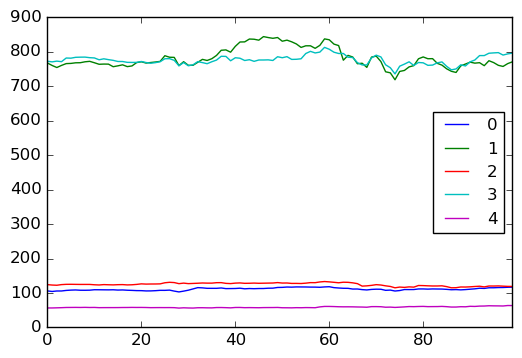

In [59]:
pd.DataFrame(rs[1].get('ds_testX')).plot()